In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load RFM features
df = pd.read_excel("../data/transactions.xlsx", engine='openpyxl')  # or reuse from previous notebook
# 2. Basic Inspection
df.info()
df.describe()
df.isnull().sum()
# 3. Data Cleaning Checks
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df = df.dropna(subset=['CustomerID'])

# Remove cancelled or negative quantity orders
df = df[df['Quantity'] > 0]

# Create Amount column = Quantity * UnitPrice
df['Amount'] = df['Quantity'] * df['UnitPrice']

# Now you can filter by Amount if needed
df = df[df['Amount'] > 0]

df_clean = df[['CustomerID', 'InvoiceDate', 'Amount']].copy()

# Check
df_clean.head()

# 4. RFM Feature Engineering
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'CustomerID': 'count',
    'Amount': 'sum'
}).rename(columns={'InvoiceDate':'Recency','CustomerID':'Frequency','Amount':'Monetary'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
# 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

Text(0.5, 1.0, 'Silhouette Score')

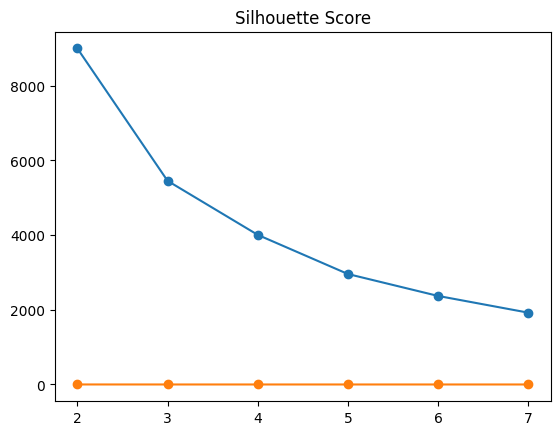

In [10]:
# 3. Find optimal clusters
inertia = []
silhouette = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

plt.plot(range(2,8), inertia, marker='o')
plt.title("Elbow Method (Inertia)")

plt.plot(range(2,8), silhouette, marker='o')
plt.title("Silhouette Score")

In [11]:
# 4. Final Model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

In [12]:
# 5. Cluster Profiling
rfm.groupby('Cluster').mean()

,Recency,Frequency,Monetary
Cluster,,,
0,41.341133,104.582512,2091.817116
1,2.000000,5807.000000,70925.287500
2,247.308333,27.787963,637.318510
3,7.666667,826.833333,190863.461667
